<a href="https://colab.research.google.com/github/gabrielfreire08/ATSIA/blob/main/atsia_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ignorar

In [1]:
#hide
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [2]:
#hide
# from fastbook import *

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para Proyecto](#path)
- [3 - Análisis de Datos Exploratorios (EDA)](#eda)
- [4 - Data Augmentation](#aug)
- [5 - Metadata](#meta)
- [6 - Carga de imágenes y metadata](#carga)
- [7 - Creación de DataBlock](#db)
- [8 - Función de Accuracy: ATSIA_ACC](#acc_atsia)
- [9 - Función de Pérdida: Binary Cross-Entropy with Logits Loss](#loss_fun)
- [10 - Modelo](#model)
- [11 - Métricas](#metrics)
- [12 - Resutados](#results)
- [13 - Widget Prueba](#widget)

<a name='lib'></a>
## Librerías

In [3]:
from fastai.vision.all import *
from fastai.vision.widgets import *

import os
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [4]:
main_path = Path(os.getcwd())
Path.BASE_PATH = main_path

In [5]:
path = Path(main_path, "img")

## Obtención de imágenes del dataset

In [6]:
fns = get_image_files(path)
fns

(#2065) [Path('img/Branquias/1 (131).png'),Path('img/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (226).png'),Path('img/Branquias/1 (206).png'),Path('img/Branquias/1 (62).png'),Path('img/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (237).png'),Path('img/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (122).png'),Path('img/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (119).png'),Path('img/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (45).png'),Path('img/Branquias/1 (134).png'),Path('img/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (198).png')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink);

<a name='db'></a> 
## Creación de DataBlock

In [9]:
def get_data(presize, resize):
    return DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_items = get_image_files,
                     item_tfms = Resize(presize, method='crop', pad_mode='zeros'), # RatioResize(500)
                     splitter = RandomSplitter(valid_pct=0.2, seed=42),
                     get_y = parent_label,
                     batch_tfms =[*aug_transforms(size = resize,
                                                  mult=1.0,
                                                  do_flip=True,
                                                  flip_vert=True,
                                                  max_rotate=10.0, 
                                                  min_zoom=1.0, 
                                                  max_zoom=1.2,   
                                                  mode='bilinear', 
                                                  pad_mode='zeros',  
                                                  min_scale=0.75),Normalize.from_stats(*imagenet_stats)]
                    )

In [10]:
dblock = get_data(500, 250)

### Creación del Dataset

In [11]:
dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=451x444, TensorCategory(2))

In [12]:
dsets.train[0][1]

TensorCategory(2)

In [13]:
idxs = int(dsets.train[0][1])
dsets.train.vocab[idxs]

'Hepatopancreas'

### Creación del datablock

### Con batchsize = 16

In [14]:
# dblock = get_data(500, 250)
dls = dblock.dataloaders(path, bs=16)

/home/ubuntu/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [15]:
print(len(dls.vocab))
labels = dls.vocab
print(labels)

5
['AmpollaRectal', 'Branquias', 'Hepatopancreas', 'Intestinos', 'Uropodos']


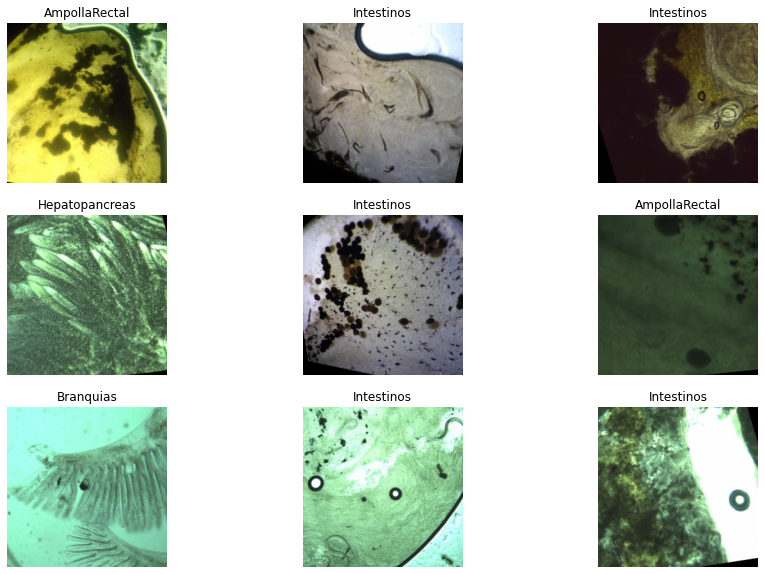

In [16]:
dls.show_batch(nrows=3, ncols=3, figsize=(15,10))

<a name='model'></a> 
## Modelo

In [17]:
learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = [accuracy, error_rate],
                    path = main_path
                    )

SuggestedLRs(valley=0.0003981071640737355)

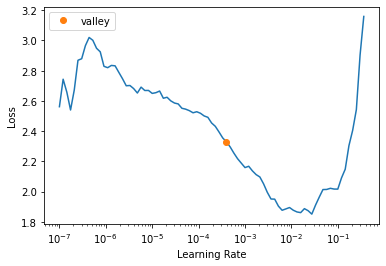

In [18]:
learn.lr_find()

In [18]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(5e-4, 5e-2), cbs = cbs)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.374212,0.955657,0.745763,0.254237,03:06
1,1.817959,0.753271,0.799031,0.200969,03:06
2,1.134322,0.457807,0.828087,0.171913,03:06
3,0.992524,0.268893,0.898305,0.101695,03:06
4,0.923451,0.269109,0.903148,0.096852,03:05
5,0.844698,0.797695,0.852300,0.147700,03:04
6,0.847268,0.241877,0.937046,0.062954,03:08
7,0.700749,0.224558,0.946731,0.053269,03:07
8,0.668699,0.330185,0.944310,0.055690,03:07
9,0.624715,0.511562,0.949153,0.050847,03:07


Better model found at epoch 0 with accuracy value: 0.7457627058029175.
Better model found at epoch 1 with accuracy value: 0.7990314960479736.
Better model found at epoch 2 with accuracy value: 0.8280871510505676.
Better model found at epoch 3 with accuracy value: 0.8983050584793091.
Better model found at epoch 4 with accuracy value: 0.9031476974487305.
Better model found at epoch 6 with accuracy value: 0.9370459914207458.
Better model found at epoch 7 with accuracy value: 0.9467312097549438.
Better model found at epoch 9 with accuracy value: 0.9491525292396545.


In [19]:
learn.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

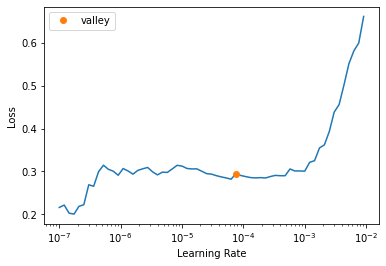

In [20]:
learn.lr_find()

In [21]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(1e-5, 1e-4), cbs = cbs)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.624718,0.497288,0.956416,0.043584,03:08
1,0.620592,0.318330,0.963680,0.036320,03:07
2,0.623326,0.248976,0.934625,0.065375,03:07
3,0.629810,0.408278,0.951574,0.048426,03:08
4,0.598116,0.836548,0.924939,0.075061,03:07
5,0.573426,1.544147,0.946731,0.053269,03:04
6,0.556481,0.525398,0.958838,0.041162,03:04
7,0.560619,1.077391,0.958838,0.041162,03:05
8,0.568669,0.599877,0.958838,0.041162,03:08
9,0.575632,2.061223,0.895884,0.104116,03:05


Better model found at epoch 0 with accuracy value: 0.9564164876937866.
Better model found at epoch 1 with accuracy value: 0.9636803865432739.


SuggestedLRs(valley=3.311311274956097e-06)

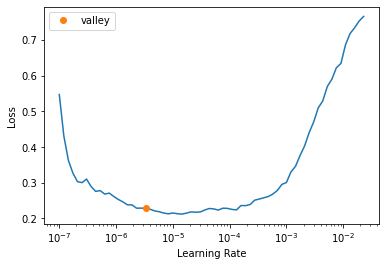

In [23]:
learn.lr_find()

In [22]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = 'model_test'),
      MixUp()]

learn.fine_tune(15, base_lr=3e-6, freeze_epochs = 5, cbs = cbs)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.609999,0.693698,0.934625,0.065375,03:09
1,0.602461,0.633887,0.937046,0.062954,03:06
2,0.624435,0.776110,0.939467,0.060533,03:05
3,0.624676,0.612272,0.937046,0.062954,03:06
4,0.608976,0.337206,0.937046,0.062954,03:04


Better model found at epoch 0 with accuracy value: 0.9346246719360352.
Better model found at epoch 1 with accuracy value: 0.9370459914207458.
Better model found at epoch 2 with accuracy value: 0.9394673109054565.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.646999,0.512970,0.944310,0.055690,03:05
1,0.619557,0.538940,0.939467,0.060533,03:09
2,0.607523,0.769953,0.941889,0.058111,03:02
3,0.618325,0.529163,0.941889,0.058111,03:01
4,0.616817,0.173100,0.949153,0.050847,03:02
5,0.621335,0.337582,0.956416,0.043584,03:08
6,0.619094,0.173321,0.951574,0.048426,03:05
7,0.602558,0.412210,0.939467,0.060533,03:07
8,0.600608,0.663212,0.934625,0.065375,03:03
9,0.621791,0.374270,0.953995,0.046005,03:05


Better model found at epoch 0 with accuracy value: 0.9443099498748779.
Better model found at epoch 4 with accuracy value: 0.9491525292396545.
Better model found at epoch 5 with accuracy value: 0.9564164876937866.
Better model found at epoch 14 with accuracy value: 0.9588377475738525.


## Realizamos Presizing

In [23]:
dblock = get_data(750, 500)
dls = dblock.dataloaders(path, bs=16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = [accuracy, error_rate],
                    path = main_path
                    )

SuggestedLRs(valley=0.0012022644514217973)

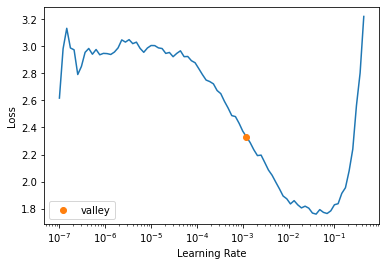

In [28]:
learn.lr_find()

In [24]:
cbs = [SaveModelCallback(monitor= 'accuracy', fname = 'model_test'),
      MixUp()]

learn.fine_tune(30, base_lr=3e-3, freeze_epochs = 10, cbs = cbs)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.518939,0.500330,0.820823,0.179177,03:27
1,1.278435,0.367617,0.864407,0.135593,03:22
2,1.155382,0.384757,0.888620,0.111380,03:22
3,1.033071,0.237943,0.912833,0.087167,03:22
4,0.945894,0.229645,0.922518,0.077482,03:21
5,0.859279,0.243241,0.922518,0.077482,03:21
6,0.827508,0.331077,0.903148,0.096852,03:24
7,0.830084,0.228113,0.939467,0.060533,03:18
8,0.751873,0.244016,0.927361,0.072639,03:19
9,0.754490,0.233179,0.937046,0.062954,03:22


Better model found at epoch 0 with accuracy value: 0.8208232522010803.
Better model found at epoch 1 with accuracy value: 0.8644067645072937.
Better model found at epoch 2 with accuracy value: 0.8886198401451111.
Better model found at epoch 3 with accuracy value: 0.9128329157829285.
Better model found at epoch 4 with accuracy value: 0.9225181341171265.
Better model found at epoch 7 with accuracy value: 0.9394673109054565.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.684519,0.169046,0.944310,0.055690,03:24
1,0.656811,0.193731,0.939467,0.060533,03:26
2,0.654405,0.167195,0.941889,0.058111,03:24
3,0.648527,0.181940,0.941889,0.058111,03:26
4,0.647287,0.171817,0.953995,0.046005,03:26
5,0.647794,0.211353,0.944310,0.055690,03:27
6,0.630973,0.298640,0.917676,0.082324,03:26
7,0.670702,0.290813,0.903148,0.096852,03:26
8,0.682124,0.173332,0.941889,0.058111,03:29
9,0.639631,0.360454,0.891041,0.108959,03:27


Better model found at epoch 0 with accuracy value: 0.9443099498748779.
Better model found at epoch 4 with accuracy value: 0.9539951682090759.
Better model found at epoch 13 with accuracy value: 0.9612590670585632.
Better model found at epoch 16 with accuracy value: 0.9636803865432739.
Better model found at epoch 19 with accuracy value: 0.9661017060279846.
Better model found at epoch 20 with accuracy value: 0.9757869243621826.
Better model found at epoch 21 with accuracy value: 0.980629563331604.


In [50]:
# cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
#       MixUp()]
# learn.fit_one_cycle(10, lr_max = slice(5e-4, 5e-2), cbs = cbs)

In [ ]:
# learn.unfreeze()

In [ ]:
# learn.lr_find()

In [ ]:
# cbs = [SaveModelCallback(monitor= 'accuracy', fname = "model_test"),
#       MixUp()]
# learn.fit_one_cycle(10, lr_max = slice(1e-5, 1e-4), cbs = cbs)

In [ ]:
# learn.lr_find()

In [ ]:
# cbs = [SaveModelCallback(monitor= 'accuracy', fname = 'model_test'),
#       MixUp()]

# learn.fine_tune(15, base_lr=3e-6, freeze_epochs = 5, cbs = cbs)

<a name='metrics'></a> 
## Métricas

In [28]:
learn.load("model_test_multiclass_09806")

In [29]:
learn.metrics = accuracy
learn.validate()

(#2) [0.11147066205739975,0.980629563331604]

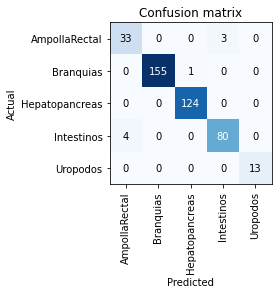

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [31]:
interp.most_confused()

[('Intestinos', 'AmpollaRectal', 4),
 ('AmpollaRectal', 'Intestinos', 3),
 ('Branquias', 'Hepatopancreas', 1)]

In [32]:
interp.print_classification_report()

                precision    recall  f1-score   support

 AmpollaRectal       0.89      0.92      0.90        36
     Branquias       1.00      0.99      1.00       156
Hepatopancreas       0.99      1.00      1.00       124
    Intestinos       0.96      0.95      0.96        84
      Uropodos       1.00      1.00      1.00        13

      accuracy                           0.98       413
     macro avg       0.97      0.97      0.97       413
  weighted avg       0.98      0.98      0.98       413



In [33]:
interp.top_losses(13)

torch.return_types.topk(
values=TensorBase([3.7941, 3.3714, 2.5381, 2.4946, 2.3612, 2.1280, 1.8658, 1.1892, 0.9275,
        0.8842, 0.8553, 0.6175, 0.6095]),
indices=TensorBase([159, 401, 247, 342, 201,  73, 265, 309,  44, 275, 136, 188, 272]))

In [36]:
x = 0
for i, loss in zip(interp.top_losses(8).indices, interp.top_losses(13).values):
    print(f"[{x}] {dls.valid_ds.items[i]} Loss: {int(loss)}")
    x += 1

[0] /home/ubuntu/ATSIA/img/Intestinos/IS_730.png Loss: 3
[1] /home/ubuntu/ATSIA/img/Branquias/S_G0_M_G0_N_G0_P_G0_AF_G0  (185).png Loss: 3
[2] /home/ubuntu/ATSIA/img/Intestinos/IS_626.png Loss: 2
[3] /home/ubuntu/ATSIA/img/AmpollaRectal/GG_G4_N_G0 (3).png Loss: 2
[4] /home/ubuntu/ATSIA/img/AmpollaRectal/GG_G2_N_G1 (2).png Loss: 2
[5] /home/ubuntu/ATSIA/img/AmpollaRectal/GG_G0_N_G0 (5).png Loss: 2
[6] /home/ubuntu/ATSIA/img/Intestinos/IMG-20210525-WA0039.png Loss: 1
[7] /home/ubuntu/ATSIA/img/Intestinos/IS_780.png Loss: 1


In [37]:
preds,targs = learn.get_preds()

In [38]:
preds[0]

TensorBase([1.2358e-04, 9.8140e-01, 1.5742e-02, 2.2269e-03, 5.0867e-04])

In [39]:
targs[0]

TensorCategory(1)

<a name='results'></a> 
## Resultados

In [ ]:
dblock = get_data(750, 500)
dls = dblock.dataloaders(path, bs=16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = [accuracy, error_rate],
                    path = main_path
                    )

In [41]:
learn.load("model_test_multiclass_09806")

In [42]:
learn.metrics = accuracy
learn.validate()

(#2) [0.11147066205739975,0.980629563331604]

In [43]:
learn.export()

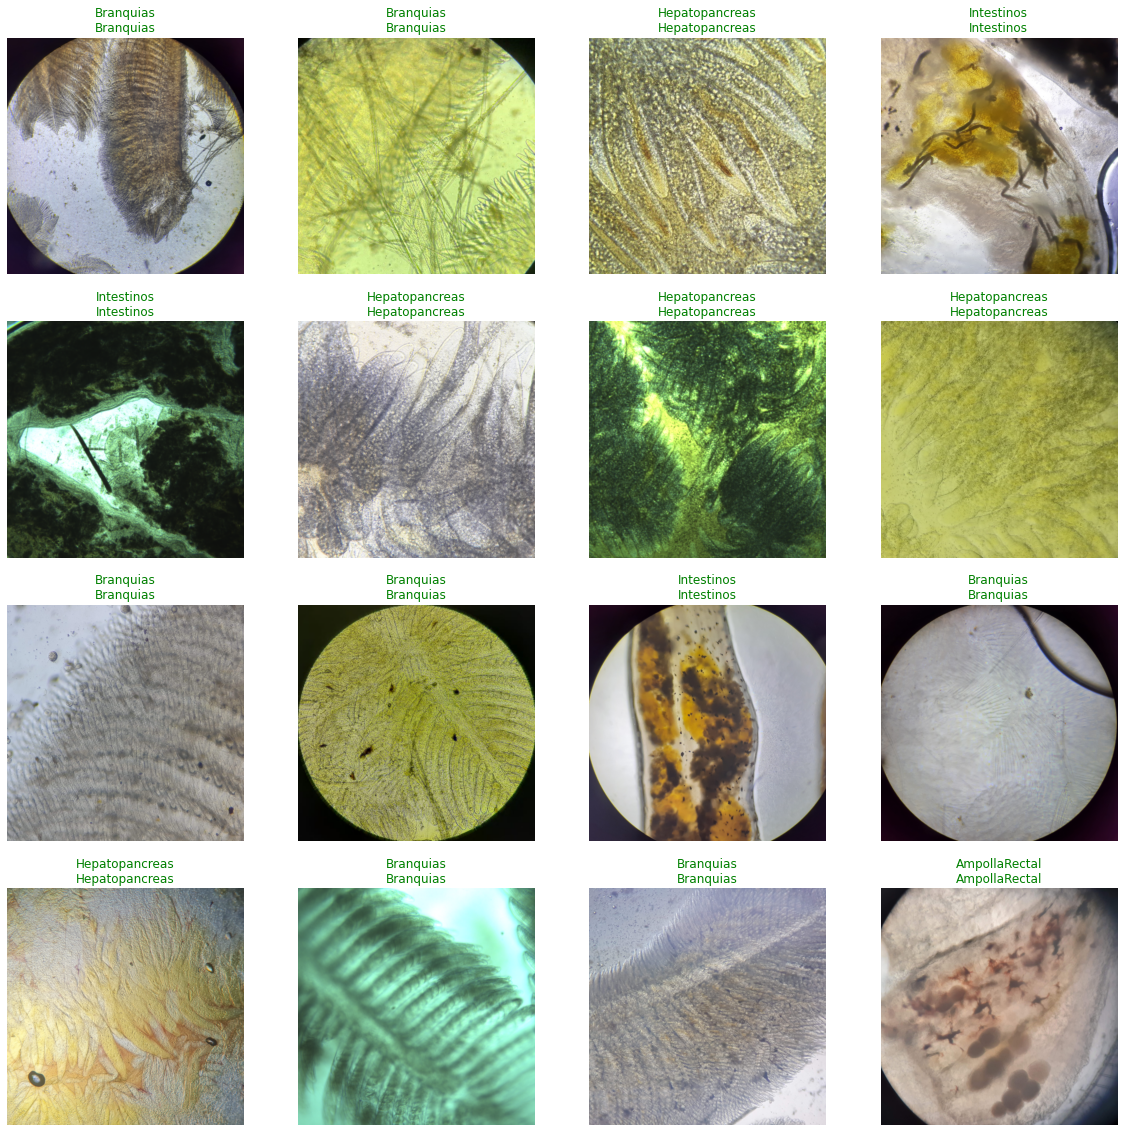

In [44]:
learn.show_results(dl = dls.valid, ds_idx = 0, max_n = 16, figsize = (20,20), shuffle=True)

<a name='widget'></a> 
## Widget Test

In [45]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [46]:
img = PILImage.create(btn_upload.data[-1])

In [47]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(500,500))
out_pl

Output()

In [48]:
pred,pred_idx,probs = learn.predict(img)
pred

'AmpollaRectal'

## Conclusion